# Lab 16 Assignment 3 - Group Assignment - Group O-1-7

## Instructions

When creating ML models, the concept of efficiency has three sides:
1. The time dedicated by the analyst to build the model
2. The computer time and resources needed by the final model
3. The accuracy of the final model

Efficiency is a combination of all

In this assignment, you are asked to be efficient. Spark is the best tool to build models over massive datasets

If you need to create Spark+Python Machine Learning models that "run fast" on the  cluster, you must avoid using Python code or working with RRD+python. Try to use  the already existing methods that do what you need (do not reinvent the wheel).

Therefore try to use the implemented object+methods inside the Spark SQL and ML modules. They are very fast, because it is compiled Java/Scala code. Try to use: DataFrames, Feature Transfomers, Estimators, Pipelines, GridSearch, CV, ...

For this assignment, you are asked to create a classification model that:
1. Uses the variables in the dataset (train.csv) to predict label "loan_status"
2. Write a python scripts that:
    - Reads the "train.csv" and "test.csv" files, transform and select variables as you wish.
    - Train/fit your model using the "train.csv".
    - Predict your model on the "test.csv" ( you should generate a file with your predictions).
    - I will use a different test dataset (with the true loan_status).

Your work will be evaluated under the following scoring schema
- (40%) ETL process
- (40%) Model train process
- (10%) Code Readability 
- (10%) AUC on the test set (at least 50%)

Enjoy it and best of luck!!

This Assignment is based on kaggle competition https://www.kaggle.com/c/loan-default-prediction from where a sub-dataset has been taken.

### File Description

**train.csv** - the training set (to use for building a model)

**test.csv** - the test set (to use for applying predictings)

**sample_submission.csv** - a template for the submission file

### Data Description (contained in LendingClub_DataDescription.csv)

**ID**: A unique LC assigned ID for the loan listing.

**loan_amnt**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

**loan_status**: Current status of the loan (**Target**: 1 = Charged Off, 0 = Fully Paid).

**term**: The number of payments on the loan. Values are in months and can be either 36 or 60.

**int_rate**: Interest Rate on the loan.

**installment**: The monthly payment owed by the borrower if the loan originates.

**emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

**home_ownership**: The home ownership status provided by the borrower during registration. Our values are: OTHER/NONE, MORTGAGE, OWN, RENT.

**annual_inc**: The self-reported annual income provided by the borrower during registration.

**purpose**: A category provided by the borrower for the loan request.

**title**: The loan title provided by the borrower.

**STATE**: The state provided by the borrower in the loan application.

**delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.

**revol_bal**: Total credit revolving balance.

**revol_util**: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

**total_pymnt**: Indicates total payment at the end of the loan.

## Data Loading

### Librairies

In [1]:
import os
import sys

os.environ['SPARK_HOME'] = "/Users/Ashley/Documents/spark-2.3.2-bin-hadoop2.7/"

# Create a variable for our root path
SPARK_HOME = os.environ['SPARK_HOME']

#Add the following paths to the system path. Please check your installation
#to make sure that these zip files actually exist. The names might change
#as versions change.
sys.path.insert(0,os.path.join(SPARK_HOME,"python"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","pyspark.zip"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","py4j-0.10.7-src.zip"))

#Initialize SparkSession and SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.functions import col
from pyspark.sql.functions import isnan, when, count
from pyspark.sql.functions import *
from pyspark.ml.classification import RandomForestClassificationModel, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.param import Params
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import MinMaxScaler
import pandas as pd


#Create a Spark Session
MySparkSession = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("MiPrimer") \
    .config("spark.executor.memory", "6g") \
    .config("spark.cores.max","4") \
    .getOrCreate()


#Get the Spark Context from Spark Session    
MySparkContext = MySparkSession.sparkContext

### Reading and Displaying Files

In [2]:
loanDF = MySparkSession.read.format('csv') \
                .option("inferSchema", "true") \
                .option("delimiter", ";") \
                .option('header','true') \
                .load('./data/train.csv') 

testDF = MySparkSession.read.format('csv') \
                .option("inferSchema", "true") \
                .option("delimiter", ";") \
                .option('header','true') \
                .load('./data/test.csv')

In [3]:
loanDF.limit(10).toPandas()

,ID,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,title,STATE,delinq_2yrs,revol_bal,revol_util,total_pymnt,loan_status
0,2,2500,60 months,15.27%,59.83,< 1 year,RENT,30000.0,car,bike,GA,0,1687,0.094,1014.530000,1
1,4,10000,36 months,13.49%,339.31,10+ years,RENT,49200.0,other,personel,CA,0,5598,0.21,12231.890000,0
2,5,3000,60 months,12.69%,67.79,1 year,RENT,80000.0,other,Personal,OR,0,27783,0.539,4066.908161,0
3,6,5000,36 months,7.90%,156.46,3 years,RENT,36000.0,wedding,My wedding loan I promise to pay back,AZ,0,7963,0.283,5632.210000,0
4,7,7000,60 months,15.96%,170.08,8 years,RENT,47004.0,debt_consolidation,Loan,NC,0,17726,0.856,10137.840010,0
5,8,3000,36 months,18.64%,109.43,9 years,RENT,48000.0,car,Car Downpayment,CA,0,8221,0.875,3939.135294,0
6,10,5375,60 months,12.69%,121.45,< 1 year,RENT,15000.0,other,Building my credit history.,TX,0,9279,0.365,1484.590000,1
7,11,6500,60 months,14.65%,153.45,5 years,OWN,72000.0,debt_consolidation,High intrest Consolidation,AZ,0,4032,0.206,7678.017673,0
8,12,12000,36 months,12.69%,402.54,10+ years,OWN,75000.0,debt_consolidation,Consolidation,CA,0,23336,0.671,13947.989160,0
9,14,3000,36 months,9.91%,96.68,3 years,RENT,15000.0,credit_card,citicard fund,IL,0,7323,0.431,3480.269999,0


In [4]:
testDF.limit(10).toPandas()

,ID,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,title,STATE,delinq_2yrs,revol_bal,revol_util,total_pymnt,loan_status
0,1,5000,36 months,10.65%,162.87,10+ years,RENT,24000.0,credit_card,Computer,AZ,0,13648,0.84,5863.155187,1
1,3,2400,36 months,15.96%,84.33,10+ years,RENT,12252.0,small_business,real estate business,IL,0,2956,0.99,3005.666844,1
2,9,5600,60 months,21.28%,152.39,4 years,OWN,40000.0,small_business,Expand Business & Buy Debt Portfolio,CA,0,5210,0.33,647.500000,1
3,13,9000,36 months,13.49%,305.38,< 1 year,RENT,30000.0,debt_consolidation,freedom,VA,0,10452,0.92,2277.320000,1
4,15,10000,36 months,10.65%,325.74,3 years,RENT,100000.0,other,Other Loan,CA,0,11997,0.56,7471.990000,1
5,18,3600,36 months,6.03%,109.57,10+ years,MORTGAGE,110000.0,major_purchase,Holiday,CT,0,22836,0.16,3785.271965,1
6,26,15000,36 months,9.91%,483.38,2 years,MORTGAGE,92000.0,credit_card,No more credit card debt!,IL,0,13707,0.94,15823.999050,1
7,27,15000,36 months,14.27%,514.64,9 years,RENT,60000.0,debt_consolidation,consolidation,NY,0,5872,0.58,0.000000,1
8,29,4000,36 months,11.71%,132.31,10+ years,MORTGAGE,106000.0,debt_consolidation,Debt Consolidation,FL,1,6110,0.38,4486.293519,1
9,31,4375,36 months,7.51%,136.11,7 years,MORTGAGE,17108.0,debt_consolidation,Debt Consolidation,NY,0,11210,0.87,4899.960000,1


## EDA | Null Values | Cross Table Distribution | Covariances

### Summary of Columns

In [5]:
print('loanDF:')
loanDF.printSchema()
print('testDF:')
testDF.printSchema()

loanDF:
root
 |-- ID: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: double (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- loan_status: integer (nullable = true)

testDF:
root
 |-- ID: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: double (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable =

### Renaming | Describing | Changing Data Type

Formatting numbers:

In [6]:
loanDF = loanDF.withColumn('int_rate', regexp_replace('int_rate', '%', ''))
loanDF = loanDF.withColumn('title', regexp_replace('title', '.', ''))
loanDF = loanDF.withColumn("int_rate", loanDF["int_rate"].cast("decimal(10,0)"))
loanDF = loanDF.withColumn("revol_util", loanDF["revol_util"].cast("decimal(10,0)"))

testDF = testDF.withColumn('int_rate', regexp_replace('int_rate', '%', ''))
testDF = testDF.withColumn('title', regexp_replace('title', '.', ''))
testDF = testDF.withColumn("int_rate", testDF["int_rate"].cast("decimal(10,0)"))
testDF = testDF.withColumn("revol_util", testDF["revol_util"].cast("decimal(10,0)"))

Renaming columns:

In [7]:
loanDF = loanDF.withColumnRenamed("ID","id")
loanDF = loanDF.withColumnRenamed("loan_amnt","loan_amount")
loanDF = loanDF.withColumnRenamed("term","term")
loanDF = loanDF.withColumnRenamed("home_ownership","home_ownership")
loanDF = loanDF.withColumnRenamed("int_rate","interest_rate")
loanDF = loanDF.withColumnRenamed("installment","monthly_payment")
loanDF = loanDF.withColumnRenamed("emp_length","employment_time")
loanDF = loanDF.withColumnRenamed("delinq_2yrs","deliquency_past_2years")
loanDF = loanDF.withColumnRenamed("revol_bal","revolving_balance")
loanDF = loanDF.withColumnRenamed("revol_util","revolving_utilization_rate")
loanDF = loanDF.withColumnRenamed("total_pymnt","total_payment")
loanDF = loanDF.withColumnRenamed("purpose","loan_purpose")
loanDF = loanDF.withColumnRenamed("annual_inc","annual_income")
loanDF = loanDF.withColumnRenamed("STATE","state")
loanDF = loanDF.withColumnRenamed("installment","installment")
loanDF = loanDF.withColumnRenamed("loan_status","loan_status")


testDF = testDF.withColumnRenamed("ID","id")
testDF = testDF.withColumnRenamed("loan_amnt","loan_amount")
testDF = testDF.withColumnRenamed("term","term")
testDF = testDF.withColumnRenamed("home_ownership","home_ownership")
testDF = testDF.withColumnRenamed("int_rate","interest_rate")
testDF = testDF.withColumnRenamed("installment","monthly_payment")
testDF = testDF.withColumnRenamed("emp_length","employment_time")
testDF = testDF.withColumnRenamed("delinq_2yrs","deliquency_past_2years")
testDF = testDF.withColumnRenamed("revol_bal","revolving_balance")
testDF = testDF.withColumnRenamed("revol_util","revolving_utilization_rate")
testDF = testDF.withColumnRenamed("total_pymnt","total_payment")
testDF = testDF.withColumnRenamed("purpose","loan_purpose")
testDF = testDF.withColumnRenamed("annual_inc","annual_income")
testDF = testDF.withColumnRenamed("STATE","state")
testDF = testDF.withColumnRenamed("installment","installment")
testDF = testDF.withColumnRenamed("loan_status","loan_status")

Summarizing `loanDF`:

In [8]:
numeric_df = ['loan_amount','interest_rate', 'monthly_payment','annual_income', 'deliquency_past_2years',
              'total_payment','revolving_balance','revolving_utilization_rate']

categorical_Df = ['term','employment_time', 'home_ownership', 'loan_purpose', 'title','state']

loanDF.describe('loan_amount','term','interest_rate','title','employment_time','home_ownership').show()
loanDF.describe('annual_income','loan_purpose','monthly_payment','state','deliquency_past_2years').show()
loanDF.describe('revolving_balance','revolving_utilization_rate','total_payment','loan_status').show()

+-------+------------------+----------+------------------+-----+---------------+--------------+
|summary|       loan_amount|      term|     interest_rate|title|employment_time|home_ownership|
+-------+------------------+----------+------------------+-----+---------------+--------------+
|  count|             29755|     29755|             29755|28517|          29755|         29755|
|   mean|11218.509494202655|      null|           12.0301| null|           null|          null|
| stddev| 7431.662873498601|      null|3.7181574007403158| null|           null|          null|
|    min|               500| 36 months|                 5|     |         1 year|      MORTGAGE|
|    max|             35000| 60 months|                25|    |            n/a|          RENT|
+-------+------------------+----------+------------------+-----+---------------+--------------+

+-------+----------------+------------+------------------+-----+----------------------+
|summary|   annual_income|loan_purpose|   month

In [9]:
display(testDF.describe())

DataFrame[summary: string, id: string, loan_amount: string, term: string, interest_rate: string, monthly_payment: string, employment_time: string, home_ownership: string, annual_income: string, loan_purpose: string, title: string, state: string, deliquency_past_2years: string, revolving_balance: string, revolving_utilization_rate: string, total_payment: string, loan_status: string]

In [10]:
print('Rows in loanDF:',loanDF.count())
print('Rows in testDF:',testDF.count())

Rows in loanDF: 29755
Rows in testDF: 10024


### Checking Null Values

In [11]:
remove_loanDF = loanDF.na.drop() 
remove_testDF = testDF.na.drop()  
print('Rows in loanDF with NAs:', loanDF.count() - remove_loanDF.count())
print('Rows in loanDF with no NAs:',remove_loanDF.count())
print()
print('Rows in testDF with NAs:', testDF.count() - remove_testDF.count())
print('Rows in testDF with no NAs:',remove_testDF.count())

Rows in loanDF with NAs: 1982
Rows in loanDF with no NAs: 27773

Rows in testDF with NAs: 908
Rows in testDF with no NAs: 9116


### Cross Table Distribution

In [12]:
# cross tables distribution
loanDF.stat.crosstab('employment_time', 'term').show()
loanDF.stat.crosstab('home_ownership', 'term').show()
loanDF.stat.crosstab('loan_purpose', 'term').show()
loanDF.stat.crosstab('state', 'term').show()
loanDF.stat.crosstab('home_ownership', 'employment_time').show()
loanDF.stat.crosstab('loan_purpose', 'employment_time').show()
loanDF.stat.crosstab('state', 'employment_time').show()
loanDF.stat.crosstab('loan_purpose', 'home_ownership').show()
loanDF.stat.crosstab('state', 'home_ownership').show()
loanDF.stat.crosstab('state', 'loan_purpose').show()

+--------------------+----------+----------+
|employment_time_term| 36 months| 60 months|
+--------------------+----------+----------+
|             5 years|      1773|       724|
|             6 years|      1175|       495|
|             3 years|      2314|       748|
|             8 years|       777|       333|
|              1 year|      1943|       497|
|            < 1 year|      2752|       694|
|             9 years|       672|       268|
|                 n/a|       585|       207|
|             4 years|      1927|       664|
|           10+ years|      4321|      2284|
|             7 years|       943|       389|
|             2 years|      2524|       746|
+--------------------+----------+----------+

+-------------------+----------+----------+
|home_ownership_term| 36 months| 60 months|
+-------------------+----------+----------+
|              OTHER|        69|         0|
|                OWN|      1703|       569|
|           MORTGAGE|      8973|      4315|
|              

+---------------------------+--------+----+-----+---+----+
|loan_purpose_home_ownership|MORTGAGE|NONE|OTHER|OWN|RENT|
+---------------------------+--------+----+-----+---+----+
|                       null|     544|   0|    3| 78| 604|
|             major_purchase|     669|   0|    6|162| 749|
|         debt_consolidation|    5595|   1|   29|960|6820|
|                credit_card|    1632|   0|    9|214|1839|
|           home_improvement|    1699|   0|    3|240| 190|
|           renewable_energy|      44|   0|    0|  2|  22|
|             small_business|     665|   0|    5| 74| 543|
|                     moving|      79|   0|    0| 17| 316|
|                        car|     558|   0|    1|115| 447|
|                   vacation|     107|   0|    0| 20| 144|
|                educational|      62|   0|    2| 17| 155|
|                      house|     106|   0|    1| 22| 147|
|                    medical|     222|   0|    2| 47| 235|
|                    wedding|     210|   0|    0| 39| 41

### Covariance


In [13]:
for i in numeric_df:
    for j in numeric_df:
        print('Covariance of ' + i + ' and '+ j )
        print(loanDF.stat.cov(i, j))
        print("")

Covariance of loan_amount and loan_amount
55229613.06533747

Covariance of loan_amount and interest_rate
8549.319317863159

Covariance of loan_amount and monthly_payment
1436013.2198559118

Covariance of loan_amount and annual_income
128790952.5486099

Covariance of loan_amount and deliquency_past_2years
-111.91643190399427

Covariance of loan_amount and total_payment
56278750.18753406

Covariance of loan_amount and revolving_balance
35052983.98744884

Covariance of loan_amount and revolving_utilization_rate
205.5056356256766

Covariance of interest_rate and loan_amount
8549.31931786316

Covariance of interest_rate and interest_rate
13.824694456679978

Covariance of interest_rate and monthly_payment
220.26613109833838

Covariance of interest_rate and annual_income
12508.30669074606

Covariance of interest_rate and deliquency_past_2years
0.27668654772190204

Covariance of interest_rate and total_payment
9885.688703886828

Covariance of interest_rate and revolving_balance
5542.1693831681

For a better readability, we plotted the correlation matrix and a pairplot using pandas dataframes.

In [14]:
import matplotlib.pyplot as plt #Plotting - version 3.0.2
import seaborn as sns #Plotting - version 0.9.0
sns.set(style='white')

loanDF_corr = loanDF.toPandas().copy()
loanDF_corr.interest_rate = loanDF_corr.interest_rate.astype(float)
loanDF_corr.revolving_utilization_rate = loanDF_corr.interest_rate.astype(float)

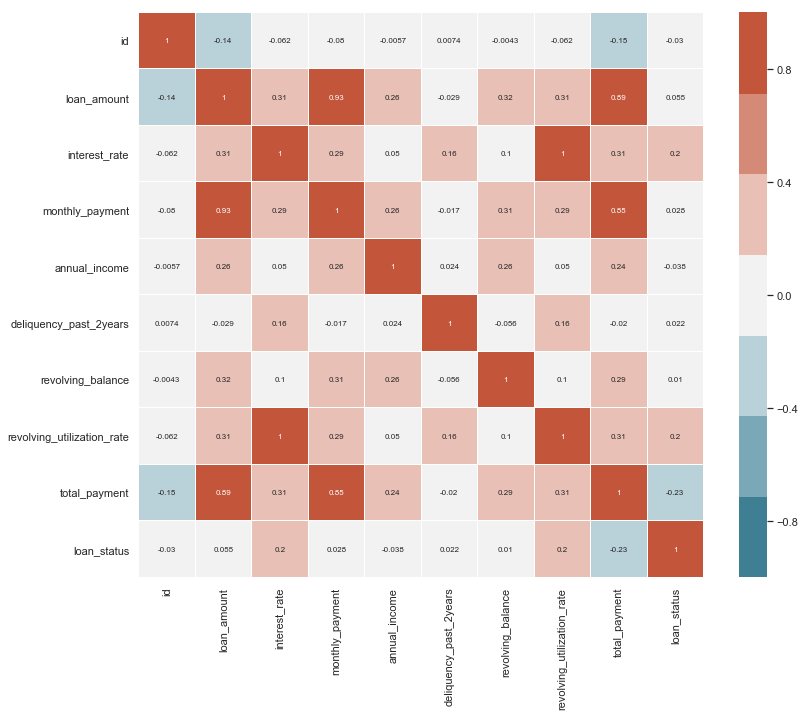

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(loanDF_corr.corr(), 
            cmap=sns.diverging_palette(220, 20, n=7), vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.tight_layout()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


<Figure size 1080x1080 with 0 Axes>

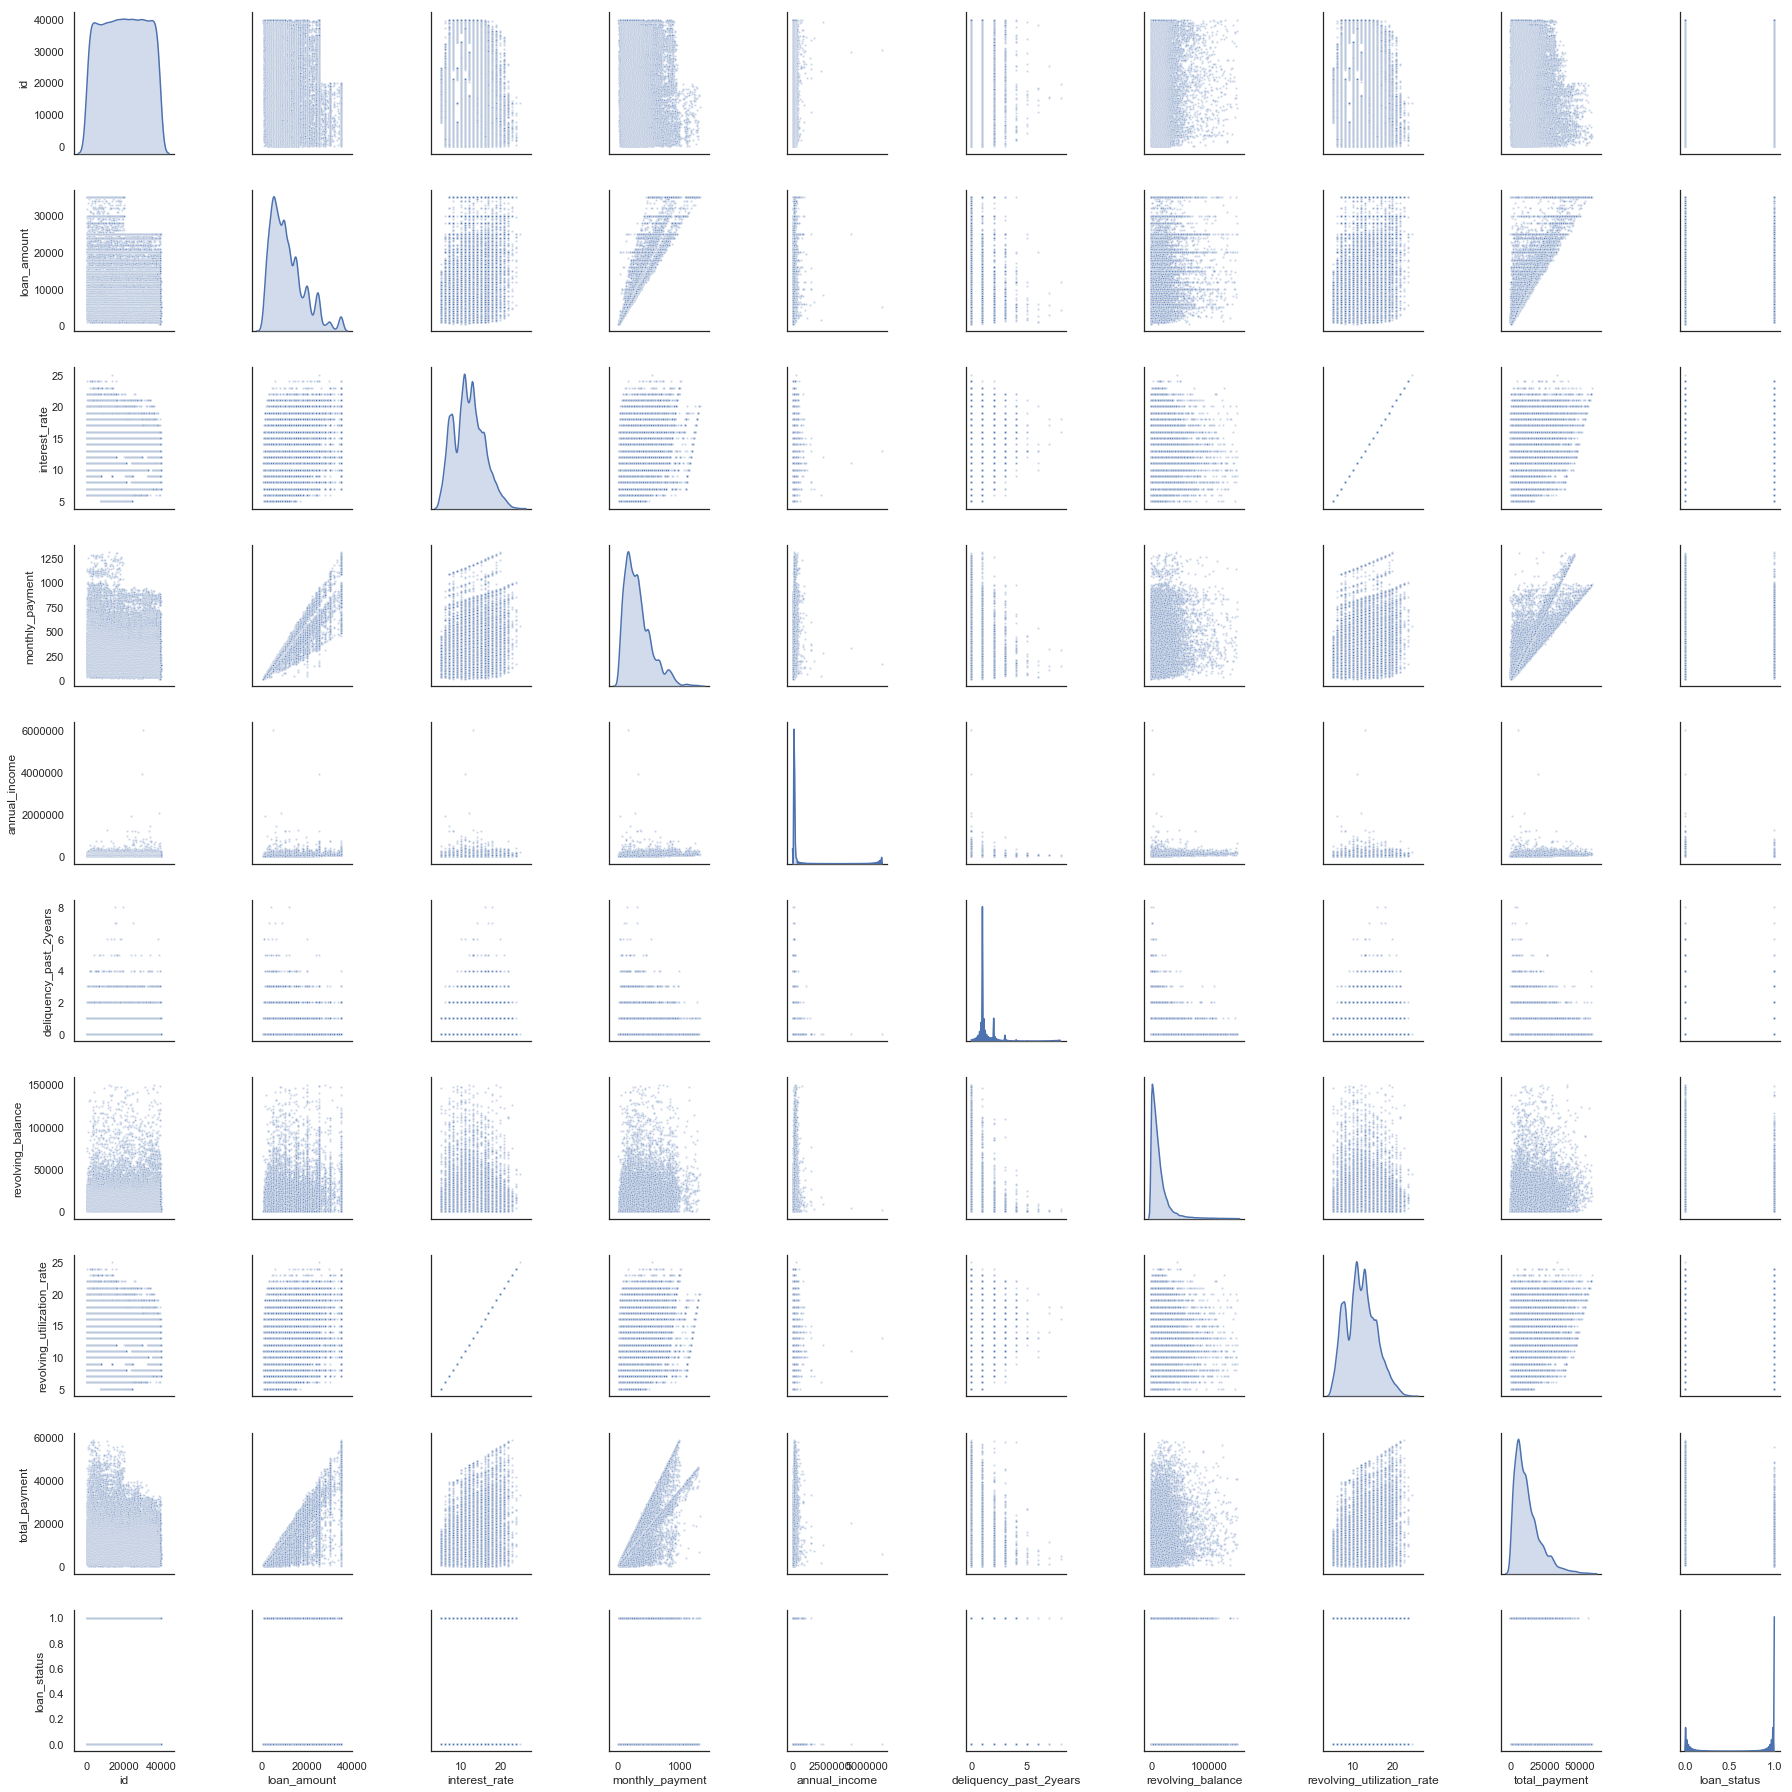

In [16]:
loanDF_pair = loanDF.toPandas().copy()
loanDF_pair.interest_rate = loanDF_pair.interest_rate.astype(float)
loanDF_pair.revolving_utilization_rate = loanDF_pair.interest_rate.astype(float)

plt.figure(figsize=(15,15))
sns.pairplot(data = loanDF_pair, diag_kind = 'kde', plot_kws = {'alpha':0.3, 's':5})
plt.tight_layout()

## ETL summary |  Spark code for Imputing 

Below we present the steps we decided to follow during our EDA in order to prepare our dataset for our machine learning implementation. It is worth mentioning that some of the steps had to be included in the previous part of the assignment in order to have a complete overview of the *cross table distributions* and the *covariances*.

1. **interest_rate** : remove special % character and change datatype from *string* to *decimal*.
2. **revol_util** : change datatype from *string* to *decimal*.
3. **Rename** columns to be better represented.
4. **Trim** the variable title as there are multiple unnecessary dots.
5. **Checkin for Na**: 
    1. Number of rows with NA for *loanDF*:    29755
    2. Number of rows without NA for *loanDF*: 27773
    3. Number of rows with NA for *testDF*:    10024
    4. Number of rows without NA for *testDF*: 9116
6. **Filling Na values**:
    1. **title** :                      unknown
    2. **loan_purpose** :               unknown
    3. **state** :                      unknown
    4. **deliquency_past_2years** :     -1
    5. **revolving_balance** :          13350.529071398512 (avg)
    6. **revolving_utilization_rate** : 0.5054 (avg)
    7. **total_payment** :              12143.791490200982 (avg)
7. **Drop** variables *title* and *state* cause they have too many unique values that cannot be grouped in order to apply one hot coding.


###  Imputing Null Values

In [115]:
mean_revolving_balance = loanDF.agg(avg(col("revolving_balance"))).collect()[0][0]
mean_revolving_utilization_rate = float(loanDF.agg(avg(col("revolving_utilization_rate"))).collect()[0][0])
mean_total_payment = loanDF.agg(avg(col("total_payment"))).collect()[0][0]

In [116]:
loanDF = loanDF.na.fill({'title': 'uknown', 'loan_purpose': 'unknown', 'state': 'unknown',
                         'deliquency_past_2years':-1,'revolving_balance':mean_revolving_balance,
                         'revolving_utilization_rate': mean_revolving_utilization_rate,
                         'total_payment': mean_total_payment})

testDF = testDF.na.fill({'title': 'unknown', 'loan_purpose': 'uknown', 'state': 'unknown',
                         'deliquency_past_2years':-1,'revolving_balance':mean_revolving_balance,
                         'revolving_utilization_rate': mean_revolving_utilization_rate, 'total_payment': mean_total_payment})

print('Rows in loanDF:',loanDF.count())
print('Rows in testDF:',testDF.count())

Rows in loanDF: 29755
Rows in testDF: 10024


###  Scaling

In [ ]:
for i in numeric_df:
    mean_0, sttdev_0 = loanDF.select(mean(i), stddev(i)).first()
    loanDF = loanDF.withColumn(i + '_scaled', (col(i) - mean_0) / sttdev_0)    
    
for i in numeric_df:
    mean_0, sttdev_0 = testDF.select(mean(i), stddev(i)).first()
    testDF = testDF.withColumn(i + '_scaled', (col(i) - mean_0) / sttdev_0)

###  Double checking final clean dataset

In [ ]:
loanDF.printSchema()
testDF.printSchema()

In [ ]:
numeric_df

In [ ]:
loanDF = loanDF.drop('loan_amount','interest_rate','monthly_payment','annual_income','deliquency_past_2years',
                     'total_payment','revolving_balance','revolving_utilization_rate')

testDF = testDF.drop('loan_amount','interest_rate','monthly_payment','annual_income','deliquency_past_2years',
                     'total_payment','revolving_balance','revolving_utilization_rate')

In [ ]:
loanDF.printSchema()
testDF.printSchema()

Checking all our columns to verify that we have:
   * Distinct user id so we do not need to group by.
   * Clean data format.
   * Clean cell values, (for example no Na and nan, which mean the same thing) 

In [ ]:
loanDF.describe('loan_amount_scaled','term','interest_rate_scaled','title','employment_time','home_ownership').show()
loanDF.describe('annual_income_scaled','loan_purpose','monthly_payment_scaled','state','deliquency_past_2years_scaled').show()
loanDF.describe('revolving_balance_scaled','revolving_utilization_rate_scaled').show()
loanDF.describe('total_payment_scaled','loan_status').show()

In [ ]:
# we have unique id = number of rows of dataset, so we do not need to group by.
for i in loanDF.columns:
    print(loanDF.select(i).distinct().count())
    print(loanDF.select(i).distinct().show())

At this stage we check the final structure of the table and we also decide to drop the **title** and **state** feature as they have so many different values, which makes it difficult to use in our model.

In [ ]:
loanDF = loanDF.drop("title", 'state','id')
testDF = testDF.drop("title", 'state','id')
loanDF.printSchema()
testDF.printSchema()

## Create Pipeline | Split train/test

At this stage we make the following adjustments:

1. We keep the **total_amount** column and we discard the **monthly payment**, because of high correlation between the 2. The reason for keeipng the total amount is based more on a business perspective.
2. We keep the **interest_rate** column and we discard the **revolving_utilization_rate**, as they are totally correlated.

In [ ]:
categoricalColumns = ['term', 'employment_time', 'home_ownership', 'loan_purpose']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'loan_status', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['loan_amount_scaled', 'interest_rate_scaled', 'annual_income_scaled', 'deliquency_past_2years_scaled', 
               'revolving_balance_scaled']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

Now it is time for use to define the pipeline we are going to use for all the models that are about to be tested including:
1. **Logistic Regression**
2. **Random Forest**
3. **Gradient Tree Boosting**


In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(loanDF)
loanDF = pipelineModel.transform(loanDF)
selectedCols = ['features'] + loanDF.columns
loanDF = loanDF.select(selectedCols)
loanDF.printSchema()

In [ ]:
pd.DataFrame(loanDF.take(5), columns=loanDF.columns).transpose()

In [ ]:
(trainingData, validationData) = loanDF.randomSplit([0.7, 0.3], seed=100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(validationData.count()))

## Logistic Regresion Model

### Write a function "metrics" which has a LogisticRegressionModel.summary as input attribute and produces an output of: 
1. Area under ROC
2. False Positive Rate By Label
3. True Positive Rate By Label
4. Precision By Label
5. Recall By Label
6. fMeasure By Label
7. Accuracy
8. False Positive Rate
9. True Positive Rate
10. fMeasure
11. Precision
12. Recall

In [ ]:
def metrics(trainingSummary):  
    my_formatted_list_FP = [ '%.2f' % elem for elem in trainingSummary.truePositiveRateByLabel]
    my_formatted_list_TP = [ '%.2f' % elem for elem in trainingSummary.precisionByLabel]
    my_formatted_list_P = [ '%.2f' % elem for elem in trainingSummary.falsePositiveRateByLabel]
    my_formatted_list_R = [ '%.2f' % elem for elem in trainingSummary.recallByLabel]
    
    print("AUC: " + str("%.2f" % trainingSummary.areaUnderROC))
    print('')
    print("False Positive Rate by Label: " + str(my_formatted_list_FP))
    print('')
    print("True Positive Rate by Label: " + str(my_formatted_list_P))
    print('')
    print("Precision by Label: " + str(my_formatted_list_TP))
    print('')
    print("Recall by Label: " + str(my_formatted_list_R))
    print('')
    print("fMeasure by Label: " + str(trainingSummary.fMeasureByLabel))
    print('')
    print("Accuracy: " + str("%.2f" %trainingSummary.accuracy))
    print('')
    print("False Positive Rate: " + str("%.2f" %trainingSummary.weightedFalsePositiveRate))
    print('')
    print("True Positive Rate: " + str("%.2f" %trainingSummary.weightedTruePositiveRate)) 
    print('')
    print("fMeasure: " + str(trainingSummary.weightedFMeasure))
    print('')
    print("Precision: " + str("%.2f" %trainingSummary.weightedPrecision))
    print('')
    print("Recall: " + str("%.2f" %trainingSummary.weightedRecall))

### Apply a Logistic Regresion Base Model and show the metrics by the function above

In [ ]:
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("label") \
                .setRawPredictionCol("rawPrediction")

print("We are using metric: " + evaluator.getMetricName())

In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(trainingData)
trainingSummary = lrModel.summary
metrics(trainingSummary)

In [ ]:
predictions_lr = lrModel.transform(validationData)
predictions_lr.select('rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
print('Test Area Under ROC','%.4f' %  evaluator.evaluate(predictions_lr))

### We are going to try to improve our model:
1. Using a `weight column` in our Logistic Regression Model (Take into account we are working with a unbalanced dataset)
2. Define a `ParamGridBuilder` with `regParam`, `elasticNetParam` and `maxIter` at least
3. Define an `BinaryClassificationEvaluator`
4. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:
1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which are the metrics of the best model (training) in the 5 k-fold runs? (Use the function above)
5. Which is the ROC-AUC on validation dataset?


In [ ]:
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("label") \
                .setRawPredictionCol("rawPrediction")

print("We are using metric: " + evaluator.getMetricName())

By setting the **paramGrid_lr** variable we define the set of different parameters we would like to test in order to tune our algorithm.

In [ ]:
paramGrid_lr = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.1, 0.5, 2.0, 5.0, 7.5, 10.0]) \
                .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])\
                .addGrid(lr.maxIter, [1, 5, 10, 15, 25])\
                .build()

print("Param Grid: " + str(paramGrid_lr))


cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator, numFolds=5)
cv_Model = cv.fit(trainingData)
predictions_cv = cv_Model.transform(validationData)

At this point we apply a **Cross Validation** strategy.

In [ ]:
# Before we had 0.6822 and now
print("AUC: " + str('%.2f' % evaluator.evaluate(predictions_cv)))

# Means of model accuracy
my_formatted_list_0 = [ '%.4f' % elem for elem in cv_Model.avgMetrics]
print("Means of metrics: " + str(my_formatted_list_0))

## Random Forest Model
1. Define a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

rfModel = rf.fit(trainingData)

predictions = rfModel.transform(validationData)

predictions.select('rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
print('Test Area Under ROC','%.4f' %  evaluator.evaluate(predictions))

By setting the **paramGrid_rf** variable we define the set of different parameters we would like to test in order to tune our algorithm.

In [ ]:
paramGrid_rf = ParamGridBuilder() \
                .addGrid(rf.maxDepth, [10, 20, 30]) \
                .addGrid(rf.numTrees, [10, 20, 30]) \
                .build()

print("Param Grid: " + str(paramGrid_rf))


cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator, numFolds=5)
cv_Model_rf = cv_rf.fit(trainingData)
predictions_cv_rf = cv_Model_rf.transform(validationData)

At this point we apply a **Cross Validation** strategy.

In [ ]:
# Before we had 0.6822 and now
print("AUC: " + str('%.2f' % evaluator.evaluate(predictions_cv_rf)))

# Means of model accuracy
my_formatted_list_1 = [ '%.4f' % elem for elem in cv_Model_rf.avgMetrics]
print("Means of metrics: " + str(my_formatted_list_1))

In [ ]:
#Best LR Model
best_rf = cv_Model_rf.bestModel
best_rf

##  Gradient Boosting Model
1. Defining a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least (You can use the above one)
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

In [ ]:
gbt = GBTClassifier(maxIter=10)

gbtModel = gbt.fit(trainingData)

predictions_gbt = gbtModel.transform(validationData)

predictions_gbt.select('rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
print('Test Area Under ROC','%.4f' %  evaluator.evaluate(predictions_gbt))

By setting the **paramGrid_gbt** variable we define the set of different parameters we would like to test in order to tune our algorithm.

In [ ]:
paramGrid_gbt = ParamGridBuilder() \
                    .addGrid(GBTClassifier.maxDepth, [2,5])\
                    .addGrid(GBTClassifier.maxIter, [10,20])\
                    .build()

print("Param Grid: " + str(paramGrid_gbt))


cv_gbt = CrossValidator(estimator = gbt, estimatorParamMaps = paramGrid_gbt, evaluator = evaluator, numFolds=5)
cv_Model_gbt = cv_gbt.fit(trainingData)
predictions_cv_gbt = cv_Model_gbt.transform(validationData)

At this point we apply a **Cross Validation** strategy.

In [ ]:
# Before we had 0.6822 and now
print("AUC: " + str('%.2f' % evaluator.evaluate(predictions_cv_gbt)))

# Means of model accuracy
my_formatted_list_2 = [ '%.4f' % elem for elem in cv_Model_gbt.avgMetrics]
print("Means of metrics: " + str(my_formatted_list_2))

In [ ]:
# Best GBT Model
best_gbt_model = cv_Model_gbt.bestModel
best_gbt_model

## Apply your best model to send the predictions on test

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel_final = pipeline.fit(testDF)
testDF = pipelineModel_final.transform(testDF)
selectedCols_final = testDF.columns
testDF = testDF.select(selectedCols_final)
testDF.printSchema()

In [ ]:
gbt = GBTClassifier(maxIter=10)

gbtModel_final = gbt.fit(loanDF)

predictions_final = gbtModel_final.transform(testDF)


In [ ]:
predictions_final.toPandas()

In [ ]:
# MySparkContext.stop()